# Use HDBSCAN to Cluster a .roi File

HDBSCAN is a powerful way to cluster images. Deep features can be extracted using a CNN without the an output layer connected.

In [1]:
from transformers import ViTModel, ViTImageProcessor
import numpy as np
import torch
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
import torchvision.transforms as transforms
import os, tqdm

## Load Model

In [2]:
# Load pretrained ViT base model (no classifier)
model = ViTModel.from_pretrained("google/vit-base-patch16-224-in21k")
processor = ViTImageProcessor.from_pretrained("google/vit-base-patch16-224-in21k")
model.eval().cuda()  # if using GPU

# Define preprocessing
transform = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize(mean=processor.image_mean, std=processor.image_std),
])

# Extract features
def extract_features(image: Image.Image):
    inputs = processor(images=image, return_tensors="pt").to("cuda")
    with torch.no_grad():
        outputs = model(**inputs)
    return outputs.last_hidden_state.mean(dim=1).squeeze().cpu()  # global average pooled features

In [3]:
#!pip install git+https://github.com/joefutrelle/pyifcb
import ifcb

## Open a .roi file remotely.

File to open:  
__[D20240522T042505_IFCB199](https://ifcb-data.oceanobservatories.org/timeline?dataset=PioneerMABMoored&bin=D20240522T042505_IFCB199)__


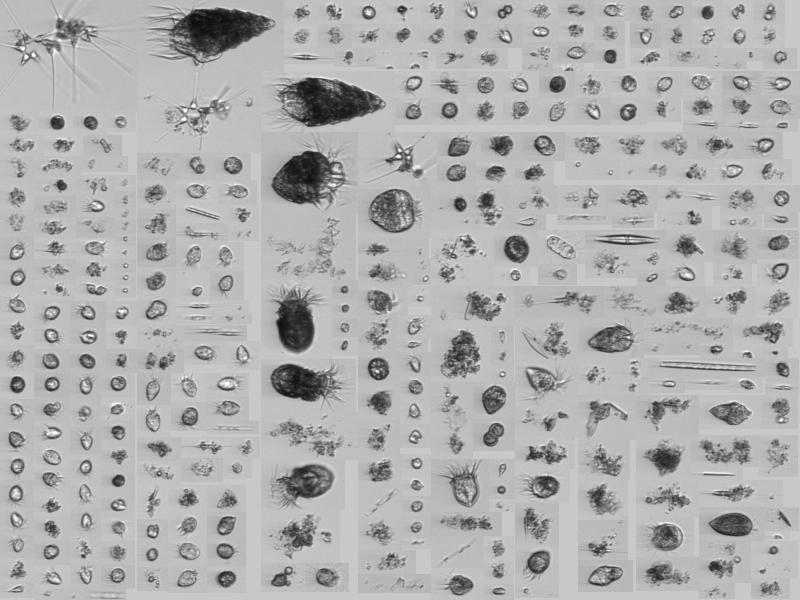

## Load Images

Find all of the loaded images.

In [4]:
full_path = "/home/jovyan/ooi/uncabled/CP10CNSM/R00001/cg_data/dcl27/plims/2024/202405/D20240522T042505_IFCB199.roi"
if os.path.isfile(full_path):
    print(f"Found {os.path.basename(full_path)}")
roi = ifcb.open_raw(full_path)
print(f"{os.path.basename(full_path)} has {roi.hdr_attributes['roiCount']} images")

Found D20240522T042505_IFCB199.roi
D20240522T042505_IFCB199.roi has 2375 images


In [5]:
class IFCBFeatureDataset(Dataset):
    def __init__(self, fileset_bin, transform=None):
        """
        Dataset for extracting deep features from IFCB .roi files.

        Args:
            fileset_bin: pyifcb.FilesetBin object containing .adc and .roi data
            transform: torchvision.transforms to apply (must handle 3-channel tensors)
        """
        self.fs = fileset_bin
        self.transform = transform
        self.roi_indices = list(self.fs.images.keys())

    def __len__(self):
        return len(self.roi_indices)

    def __getitem__(self, idx):
        roi_num = self.roi_indices[idx]
        with self.fs:
            img = self.fs.images[roi_num]  # raw grayscale image as 2D numpy array

        # Normalize and convert to float tensor
        img = torch.from_numpy(img.astype(np.float32) / 255.0).unsqueeze(0)  # shape: (1, H, W)
        img = img.repeat(3, 1, 1)  # shape: (3, H, W)

        if self.transform:
            img = self.transform(img)  # expected shape: (3, 224, 224) or similar

        return {"pixel_values": img, "roi_num": roi_num}


feature_transform = transforms.Compose([
    transforms.ToPILImage(),  # expects (H, W, C) so convert before if needed
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.485, 0.456, 0.406),
                         std=(0.229, 0.224, 0.225)),
])

In [6]:
def collate_fn(batch):
    pixel_values = torch.stack([item["pixel_values"] for item in batch])
    roi_nums = [item["roi_num"] for item in batch]
    return pixel_values, roi_nums

dataset = IFCBFeatureDataset(roi, transform=feature_transform)
loader = DataLoader(dataset, batch_size=256, shuffle=False,collate_fn=collate_fn)

In [7]:
all_features = []
all_images = []
all_indices = []
device = "cuda"

for pixel_values, roi_nums in tqdm.tqdm(loader, desc="Extracting features"):
    pixel_values = pixel_values.to(device)
    with torch.no_grad():
        features = model(pixel_values)

    all_features.append(features.pooler_output.cpu())
    all_indices.extend(roi_nums)
    all_images.append(pixel_values)

Extracting features: 100%|██████████| 10/10 [00:15<00:00,  1.57s/it]


__Save the features__

In [8]:
features_tensor = torch.cat(all_features, dim=0)
features_np = features_tensor.numpy()
np.save(f"deep_features/{os.path.basename(full_path).split(".roi")[0]}_ViT_features.npy", features_np)

array([[ 0.21930863,  0.48727572, -0.24241589, ...,  0.5216918 ,
         0.5283315 , -0.41237593],
       [ 0.20979291, -0.24535958, -0.4861548 , ...,  0.73658514,
         0.25409934, -0.21911706],
       [-0.06138143,  0.47064498, -0.57432866, ...,  0.55722404,
         0.41815886,  0.4639734 ],
       ...,
       [ 0.66900074,  0.46999907, -0.32818648, ...,  0.297895  ,
         0.00126916,  0.02446321],
       [ 0.2662158 ,  0.40224004, -0.42164612, ...,  0.52652997,
         0.42952332,  0.34565467],
       [ 0.48605695,  0.3996101 , -0.12279838, ...,  0.41815227,
         0.18875098,  0.16672534]], dtype=float32)

## Cluster Deep Features

- Starting with KMeans
    - The feature space dimensionality is reduced using [t-SNE (T-distributed Stochastic Neighbor Embedding)](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html).

In [128]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
import numpy as np
import torch
from collections import defaultdict
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE



### re-load Feature Files if skipping ahead
features_np = np.load(f"deep_features/{os.path.basename(full_path).split(".roi")[0]}_ViT_features.npy")

In [120]:
from sklearn.cluster import KMeans

n_clusters = 8  # set this based on domain knowledge or experimentation (magic!)
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(features_np)

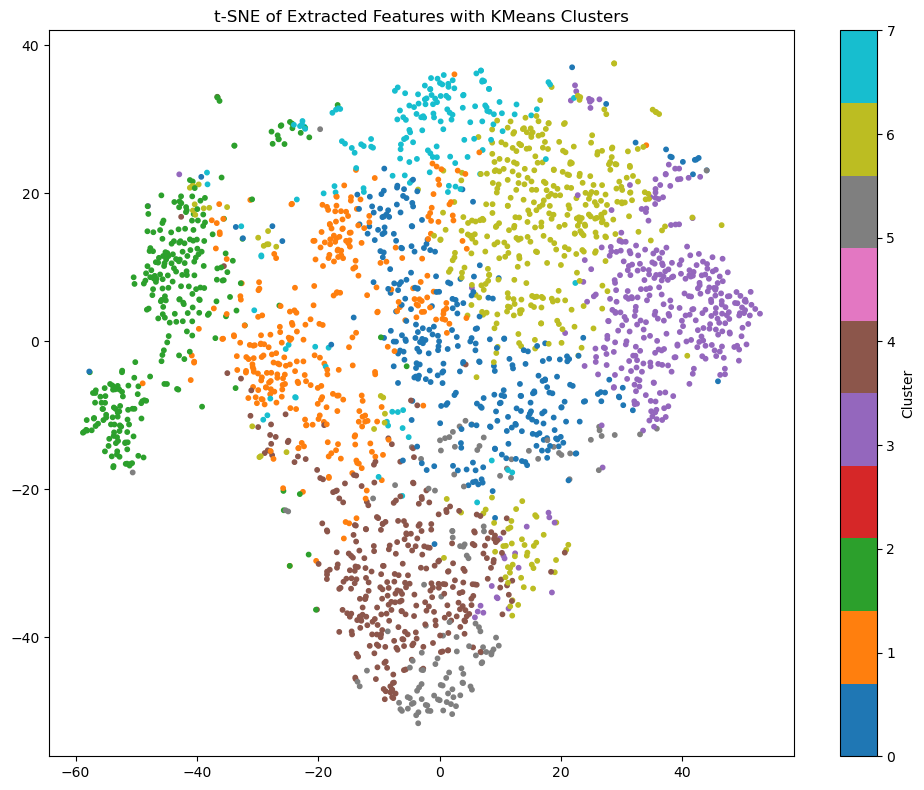

In [22]:
tsne = TSNE(n_components=2, random_state=42)
tsne_results = tsne.fit_transform(features_np)

plt.figure(figsize=(10, 8))
plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=cluster_labels, cmap="tab10", s=10)
plt.colorbar(label="Cluster")
plt.title("t-SNE of Extracted Features with KMeans Clusters")
plt.tight_layout()
plt.show()

In [23]:
# Group ROI images by cluster
cluster_to_indices = defaultdict(list)
for i, cluster in enumerate(cluster_labels):
    cluster_to_indices[cluster].append(i)

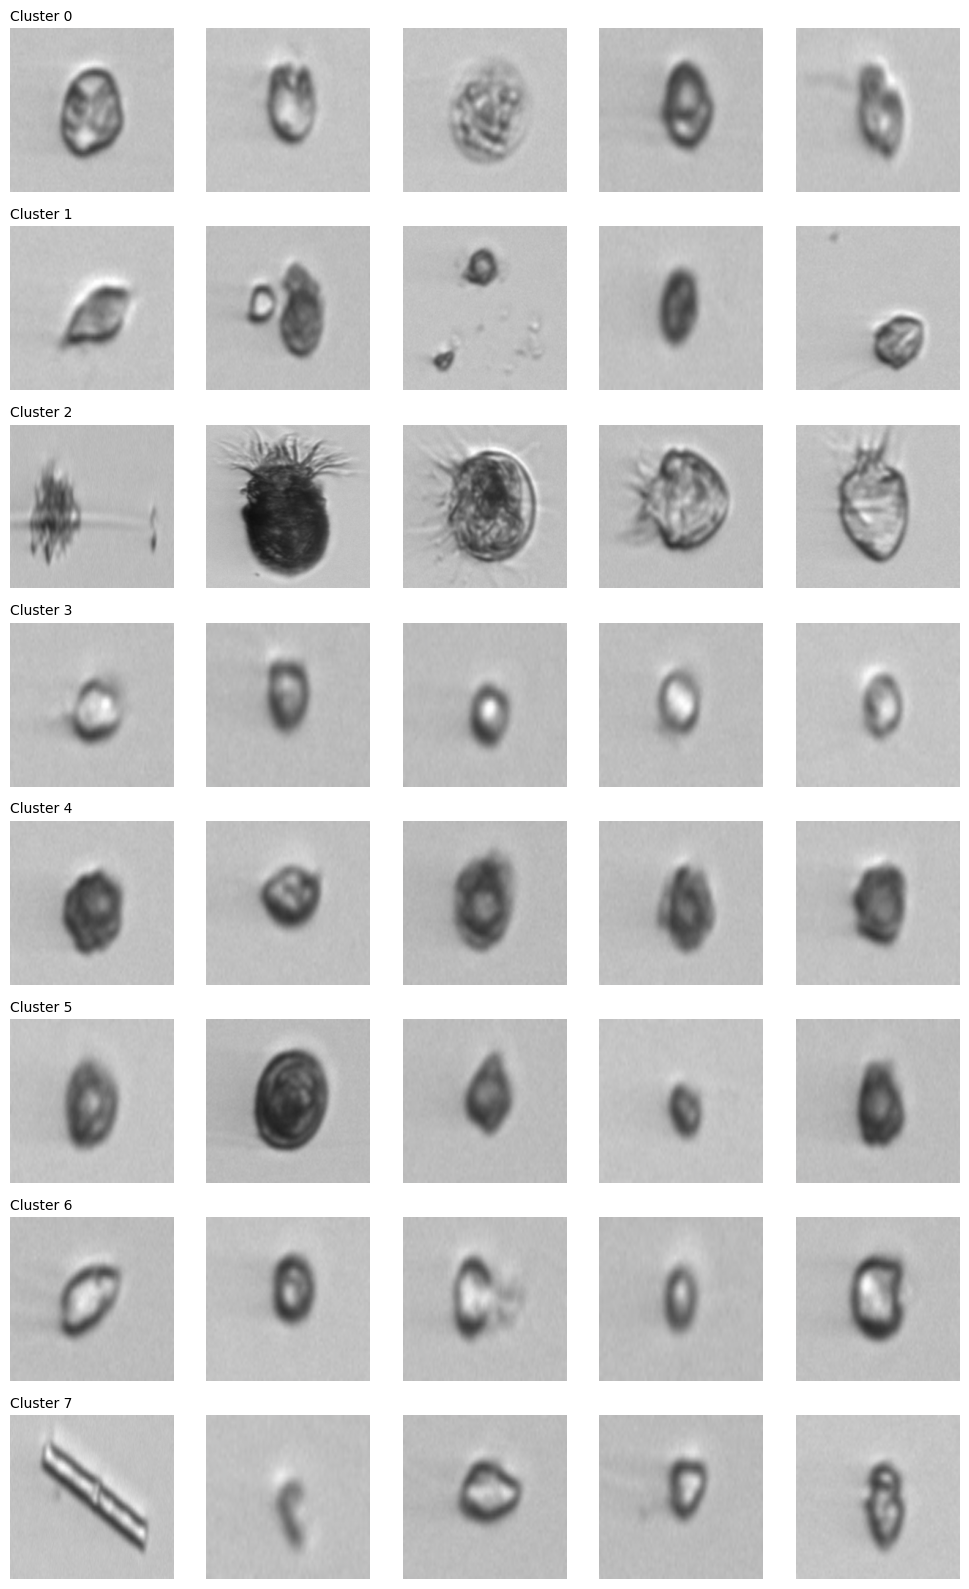

In [24]:


# Flatten all_images (batched tensors) to single tensor list
images_tensor = torch.cat(all_images, dim=0)  # shape (N, 3, H, W)

# Convert cluster_labels to a dict: cluster_id -> list of indices
from collections import defaultdict

cluster_to_indices = defaultdict(list)
for idx, label in enumerate(cluster_labels):
    cluster_to_indices[label].append(idx)

# Parameters
images_per_cluster = 5
n_clusters = len(set(cluster_labels))

# Create mosaic
fig, axs = plt.subplots(n_clusters, images_per_cluster, figsize=(images_per_cluster * 2, n_clusters * 2))

for cluster_id, indices in cluster_to_indices.items():
    selected = indices[:images_per_cluster]
    for j, idx in enumerate(selected):
        img_tensor = images_tensor[idx]  # (3, H, W)
        img_np = img_tensor.cpu().permute(1, 2, 0).numpy()

        # Unnormalize for display if necessary
        img_np = img_np * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
        img_np = np.clip(img_np, 0, 1)

        ax = axs[cluster_id, j] if n_clusters > 1 else axs[j]
        ax.imshow(img_np)
        ax.axis("off")
        if j == 0:
            ax.set_title(f"Cluster {cluster_id}", fontsize=10, loc='left')

plt.tight_layout()
# plt.savefig("ifcb_cluster_mosaic-kmeans.png", dpi=300)
plt.show()

## Cluster with HDBSCAN
- HDBSCAN will attempt to cluster with as many clusters as possible given a miniumum cluster size
- It will also try to exlcude noise

In [119]:
# !pip install hdbscan
import hdbscan

In [154]:
# Initialize and fit the HDBSCAN clusterer
clusterer = hdbscan.HDBSCAN(min_cluster_size=5,metric="euclidean")
cluster_labels = clusterer.fit_predict(tsne_results)

# HDBSCAN assigns -1 to noise points (i.e., unclustered)
n_clusters = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)
print(f"Identified {n_clusters} clusters (excluding noise):")

# Get per-cluster stability
stability = clusterer.cluster_persistence_
# Print or sort
for i, score in enumerate(stability):
    print(f"Cluster {i}: stability = {score:.3f}")

Identified 10 clusters (excluding noise):
Cluster 0: stability = 0.234
Cluster 1: stability = 0.021
Cluster 2: stability = 0.212
Cluster 3: stability = 0.125
Cluster 4: stability = 0.244
Cluster 5: stability = 0.071
Cluster 6: stability = 0.021
Cluster 7: stability = 0.000
Cluster 8: stability = 0.073
Cluster 9: stability = 0.102


## Plot the Clusters

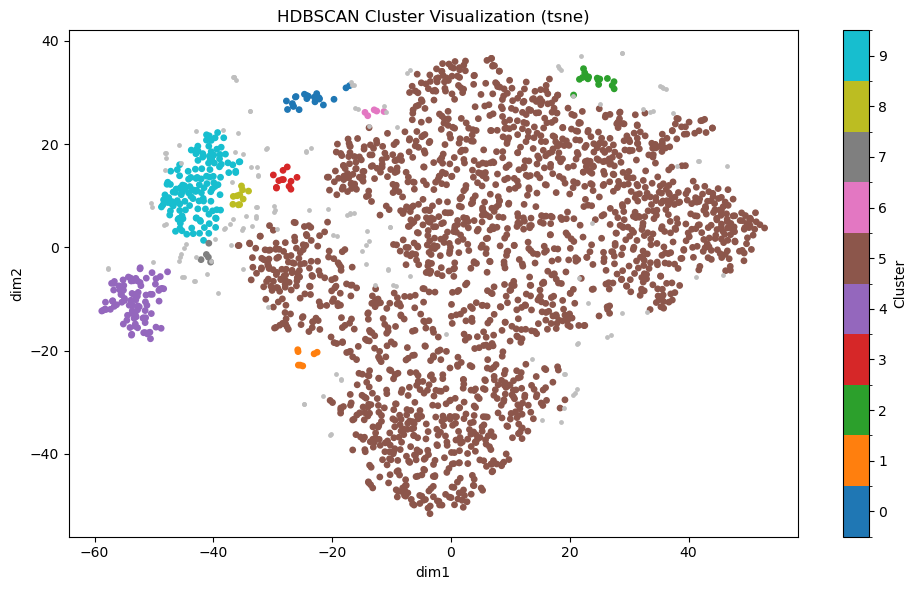

In [145]:
plt.figure(figsize=(10, 6))
cmap = plt.get_cmap("tab10", n_clusters)
boundaries = np.arange(n_clusters + 1) - 0.5  # center each color on its label
norm = mcolors.BoundaryNorm(boundaries, cmap.N)

noise = np.where(cluster_labels == -1)
data = np.where(cluster_labels != -1)

cax = plt.scatter(tsne_results[data, 0], tsne_results[data, 1], c=cluster_labels[data], s=15,cmap=cmap, norm=norm,)
plt.scatter(tsne_results[noise, 0], tsne_results[noise, 1], c=".75", s=6)
plt.title("HDBSCAN Cluster Visualization (tsne)")
plt.xlabel("dim1")
plt.ylabel("dim2")
plt.tight_layout()

# Create colorbar with centered labels
cb = plt.colorbar(cax, ticks=np.arange(n_clusters))
cb.set_label("Cluster")
cb.set_ticklabels([str(label) for label in range(0,n_clusters)])  # or use real names

# plt.savefig("ifcb_cluster-HDBSCAN.png", dpi=300)

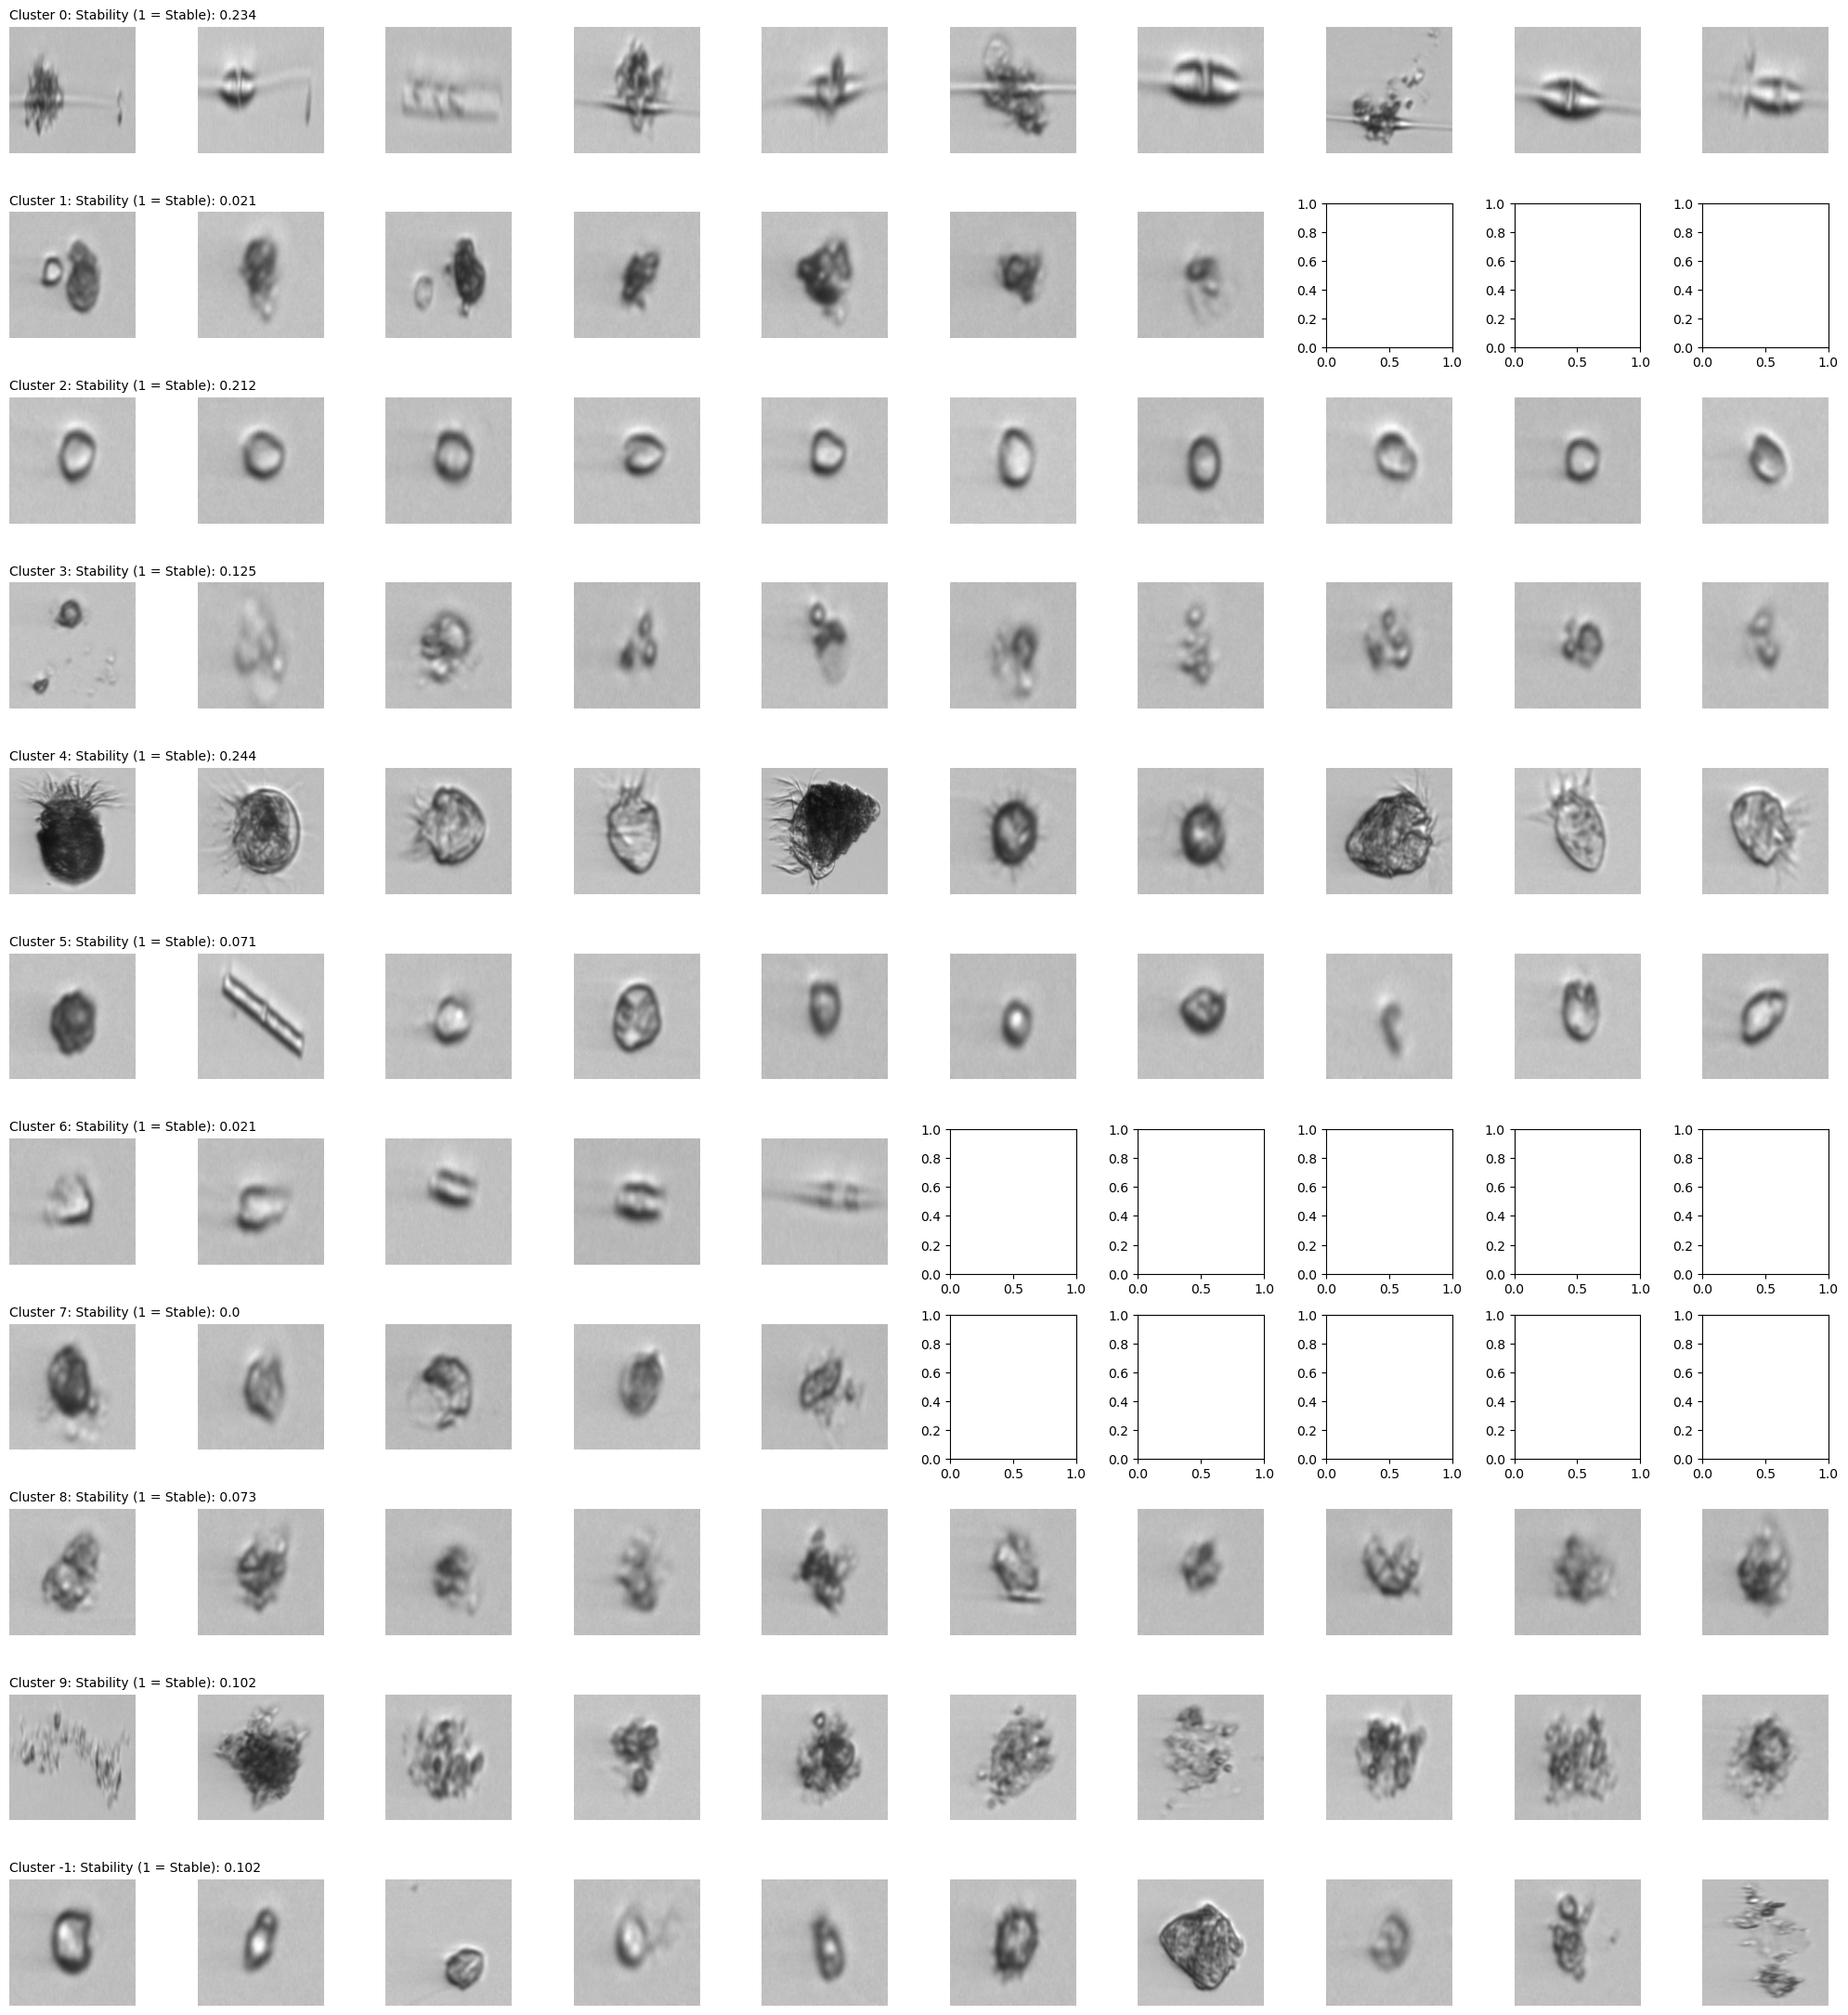

In [138]:
cluster_to_indices = defaultdict(list)
for idx, label in enumerate(cluster_labels):
    cluster_to_indices[label].append(idx)

# Parameters
images_per_cluster = 10
n_clusters = len(set(cluster_labels))

# Create mosaic
fig, axs = plt.subplots(n_clusters, images_per_cluster, figsize=(images_per_cluster * 2, n_clusters * 2))

for cluster_id, indices in cluster_to_indices.items():
    selected = indices[:images_per_cluster]
    for j, idx in enumerate(selected):
        img_tensor = images_tensor[idx]  # (3, H, W)
        img_np = img_tensor.cpu().permute(1, 2, 0).numpy()

        # Unnormalize for display if necessary
        img_np = img_np * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
        img_np = np.clip(img_np, 0, 1)

        ax = axs[cluster_id, j] if n_clusters > 1 else axs[j]
        ax.imshow(img_np)
        ax.axis("off")
        if j == 0:
            ax.set_title(f"Cluster {cluster_id}: Stability (1 = Stable): {round(stability[cluster_id],3)}", fontsize=10, loc='left')

plt.tight_layout()
# plt.savefig("ifcb_cluster_mosaic-HDBSCAN.png", dpi=300)
plt.show()

In [174]:
c5 = np.where(cluster_labels == 5)

clusterer_c5 = hdbscan.HDBSCAN(min_cluster_size=8,metric="euclidean")
cluster_labels_c5 = clusterer_c5.fit_predict(tsne_results[c5])

# HDBSCAN assigns -1 to noise points (i.e., unclustered)
n_clusters_c5 = len(set(cluster_labels_c5)) - (1 if -1 in cluster_labels_c5 else 0)
print(f"Identified {n_clusters_c5} clusters (excluding noise):")

# Get per-cluster stability
stability_c5 = clusterer_c5.cluster_persistence_
# Print or sort
for i, score in enumerate(stability_c5):
    print(f"Cluster {i}: stability = {score:.3f}")

Identified 26 clusters (excluding noise):
Cluster 0: stability = 0.070
Cluster 1: stability = 0.218
Cluster 2: stability = 0.021
Cluster 3: stability = 0.093
Cluster 4: stability = 0.027
Cluster 5: stability = 0.062
Cluster 6: stability = 0.138
Cluster 7: stability = 0.067
Cluster 8: stability = 0.093
Cluster 9: stability = 0.027
Cluster 10: stability = 0.165
Cluster 11: stability = 0.074
Cluster 12: stability = 0.006
Cluster 13: stability = 0.111
Cluster 14: stability = 0.074
Cluster 15: stability = 0.118
Cluster 16: stability = 0.171
Cluster 17: stability = 0.002
Cluster 18: stability = 0.136
Cluster 19: stability = 0.033
Cluster 20: stability = 0.100
Cluster 21: stability = 0.069
Cluster 22: stability = 0.067
Cluster 23: stability = 0.153
Cluster 24: stability = 0.042
Cluster 25: stability = 0.041


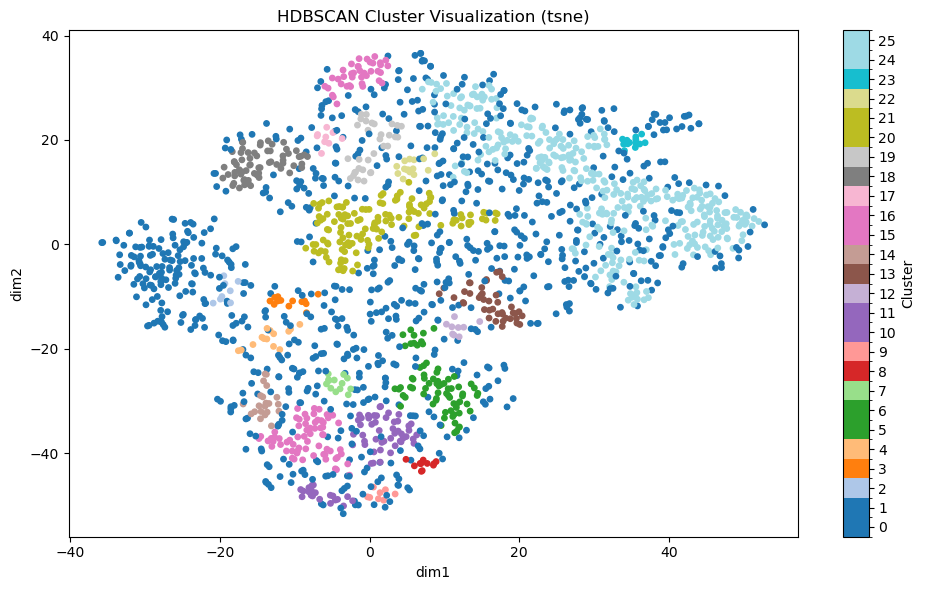

In [177]:
plt.figure(figsize=(10, 6))

cmap = plt.get_cmap("tab20", n_clusters_c5)
boundaries = np.arange(n_clusters_c5 + 1) - 0.5  # center each color on its label
norm = mcolors.BoundaryNorm(boundaries, cmap.N)

cax = plt.scatter(tsne_results[c5, 0], tsne_results[c5, 1], c=cluster_labels_c5, s=15,cmap=cmap, norm=norm,)
# plt.scatter(tsne_results[c5, 0], tsne_results[noise, 1], c=".75", s=6)
plt.title("HDBSCAN Cluster Visualization (tsne)")
plt.xlabel("dim1")
plt.ylabel("dim2")
plt.tight_layout()

# Create colorbar with centered labels
cb = plt.colorbar(cax, ticks=np.arange(n_clusters_c5))
cb.set_label("Cluster")
cb.set_ticklabels([str(label) for label in range(0,n_clusters_c5)])  # or use real names

# plt.savefig("ifcb_cluster-HDBSCAN.png", dpi=300)